# Fit simple Milky Way disk rotation model to FGKM golden sample

This notebook repeats the modelling of the Milky Way rotation curve in section 10.1 of the paper _Gaia Data Release 3: A Golden Sample of Astrophysical Parameters_ by [Gaia Collaboration, Creevey et al. (2022)]() for the FGKM golden sample.

First query the Gaia DR3 archive for the data necessary to reproduce the analysis and store in the `../data` folder.

```
select fgkm.*, gaia.ra, gaia.dec, gaia.parallax, gaia.pmra, gaia.pmdec, 
gaia.pmra_error, gaia.pmdec_error, gaia.parallax_error,
gaia.pmra_pmdec_corr, gaia.parallax_pmra_corr, gaia.parallax_pmdec_corr,
gaia.radial_velocity, gaia.radial_velocity_error, gaia.rv_template_teff, gaia.grvs_mag,
gaia.phot_g_mean_mag, gaia.bp_rp, gaia.bp_g, gaia.g_rp, ap.abp_gspphot, ap.arp_gspphot
from gaiadr3.gaia_source as gaia
join gaiadr3.gold_sample_fgkm_stars as fgkm
using (source_id)
join gaiadr3.astrophysical_parameters as ap
using (source_id)
```

The modelling steps below are the same as for the OBA star sample in [this notebook](FitMWDiskKinModel.ipynb).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import ujson, os

from scipy.stats import scoreatpercentile as scap

from cmdstanpy import set_cmdstan_path, CmdStanModel
import arviz as az
import corner

from astropy.table import Table
import astropy.units as u
import astropy.constants as c
from astropy.coordinates import Galactocentric, ICRS, CartesianDifferential
au_km_year_per_sec = (c.au / (1*u.yr).to(u.s)).to(u.km/u.s).value

from plotstyles import useagab, apply_tufte
from robuststats import rse

from gala.potential.potential.builtin.special import BovyMWPotential2014
from diskkinematicmodel import *
from icrstogal import *
from loadmwsamples import *

useagab()

/home/brown/anaconda3/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.0.6.patch is an invalid version and will not be supported in a future release
  warnings.warn(


## Read in data

In [2]:
Rsun = 8277.0*u.pc

fgkmtable = load_mwtable('../data/FGKMGoldenSample.fits', Rsun=Rsun, esphs=False)

## Several versions of HR diagram

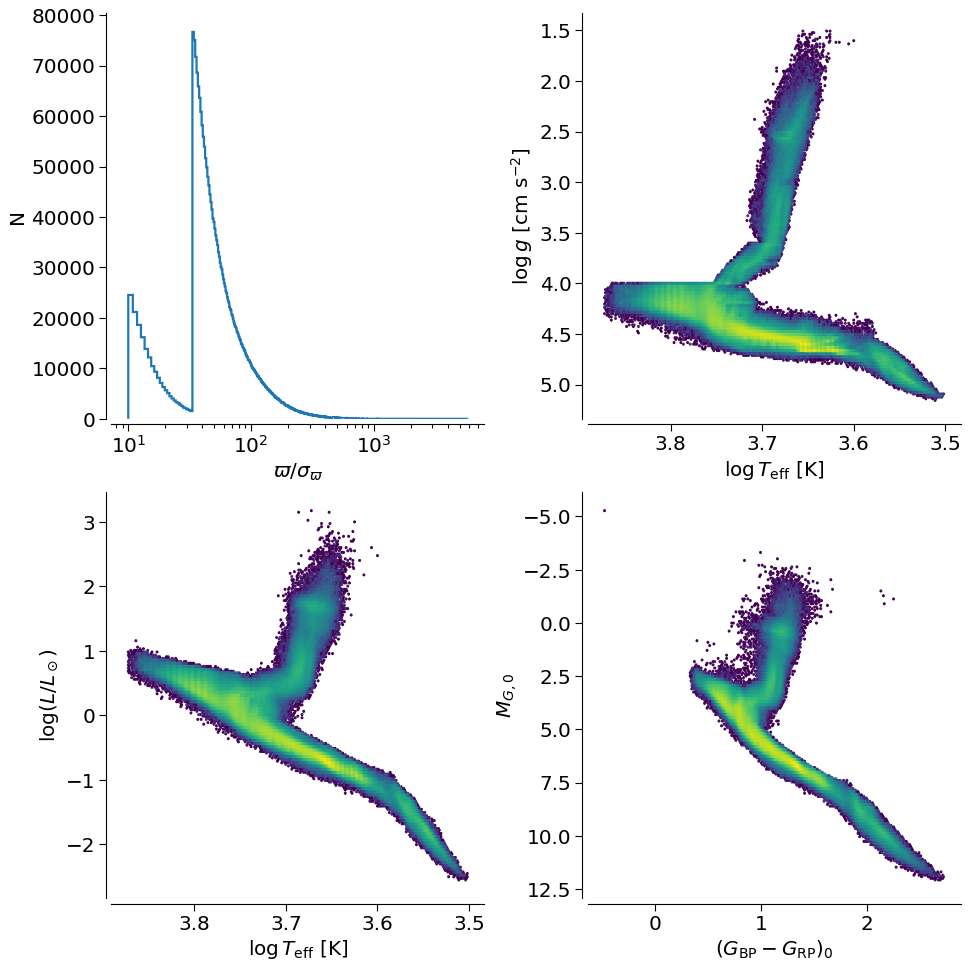

In [4]:
fig=plt.figure(constrained_layout=True, figsize=(2*6,2*6))

gs = GridSpec(2, 2, figure=fig)

axplxsnr = fig.add_subplot(gs[0,0])
apply_tufte(axplxsnr)

axplxsnr.hist(fgkmtable['parallax_over_error'], bins='auto', histtype='step', lw=2)
axplxsnr.set_xscale('log')
axplxsnr.set_xlabel(r'$\varpi/\sigma_\varpi$')
axplxsnr.set_ylabel('N')

axkiel = fig.add_subplot(gs[0,1])
apply_tufte(axkiel)
axkiel.hexbin(np.log10(fgkmtable['teff_gspphot']), fgkmtable['logg_gspphot'], bins='log', gridsize=200, mincnt=1)
axkiel.set_xlabel(r'$\log T_\mathrm{eff}$ [K]')
axkiel.set_ylabel(r'$\log g$ [cm s$^{-2}$]')
axkiel.invert_xaxis()
axkiel.invert_yaxis()
, gridsize=200
axhrd = fig.add_subplot(gs[1,0])
apply_tufte(axhrd)
axhrd.hexbin(np.log10(fgkmtable['teff_gspphot']), np.log10(fgkmtable['lum_flame']), bins='log', gridsize=200, mincnt=1)
axhrd.set_xlabel(r'$\log T_\mathrm{eff}$ [K]')
axhrd.set_ylabel(r'$\log(L/L_\odot)$')
axhrd.invert_xaxis()

axcmd = fig.add_subplot(gs[1,1])
apply_tufte(axcmd)
axcmd.hexbin(fgkmtable['bp_rp0_gspphot'], fgkmtable['mg_abs0_gspphot'], bins='log', gridsize=200, mincnt=1)
axcmd.set_xlabel(r'$(G_\mathrm{BP}-G_\mathrm{RP})_0$')
axcmd.set_ylabel(r'$M_{G,0}$')
axcmd.invert_yaxis()

plt.show()

## Select subsample

Number of stars in selected sample: 25256


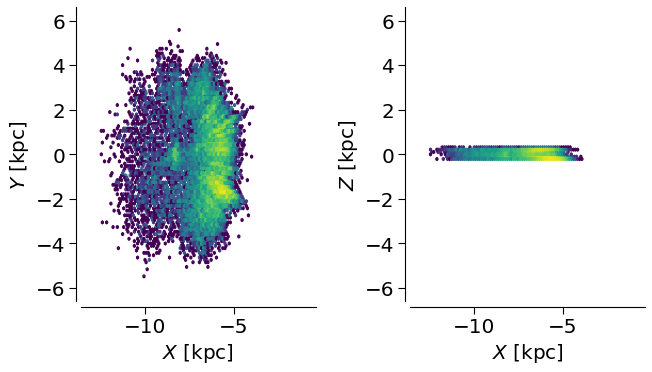

In [5]:
plx_snrlim = 10
vtanhalo = 180.0

plxfilter = fgkmtable['parallax_over_error']>plx_snrlim
zmax = 250

sample_filter_init = plxfilter & (np.abs(np.sin(np.deg2rad(fgkmtable['b']))*1000/fgkmtable['parallax']) < zmax)

R_filter = (fgkmtable['R_gc']>6500.0) & (fgkmtable['R_gc']<15000.0)

no_spt_filter = fgkmtable['source_id'] > 0
giants = fgkmtable['logg_gspphot'] <= 3.0
fstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] > 6000)
gstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 6000) & (fgkmtable['teff_gspphot'] > 5000)
kstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 5000) & (fgkmtable['teff_gspphot'] > 4000)
mstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 4000)

spt_lum_filter = giants

sample_filter = sample_filter_init & spt_lum_filter #& R_filter

print(f"Number of stars in selected sample: {fgkmtable['ra'][sample_filter].size}")

subsample_size = 3000
if (fgkmtable['ra'][sample_filter].size <=subsample_size):
    fgkm_subsample = fgkmtable[sample_filter]
else:
    random_subsample = np.random.choice(np.arange(fgkmtable['ra'][sample_filter].size), size=subsample_size, replace=False)
    fgkm_subsample = fgkmtable[sample_filter][random_subsample]
    
plotgrid = [-13, -1, -6, 6]
fig=plt.figure(figsize=(8.5,5), tight_layout=True)

gs = fig.add_gridspec(1, 2, figure=fig)

ax_xy = fig.add_subplot(gs[0,0])
apply_tufte(ax_xy)
ax_xz = fig.add_subplot(gs[0,1])
apply_tufte(ax_xz)

ax_xy.hexbin(fgkmtable['x_gc'][sample_filter]/1000, fgkmtable['y_gc'][sample_filter]/1000, mincnt=1, bins='log', extent=plotgrid)
ax_xy.set_xlabel(r'$X$ [kpc]') 
ax_xy.set_ylabel(r'$Y$ [kpc]') 

ax_xz.hexbin(fgkmtable['x_gc'][sample_filter]/1000, fgkmtable['z_gc'][sample_filter]/1000, mincnt=1, bins='log', extent=plotgrid)
ax_xz.set_xlabel(r'$X$ [kpc]') 
ax_xz.set_ylabel(r'$Z$ [kpc]')

plt.show()

## Plot histogram of $\sin(b)\times 1000/\varpi$

Use this to estimate $Z_\odot$ for this sample.

Median d*sin(b): -74.4
RSE d*sin(b): 160.7
Mean d*sin(b): -33.5


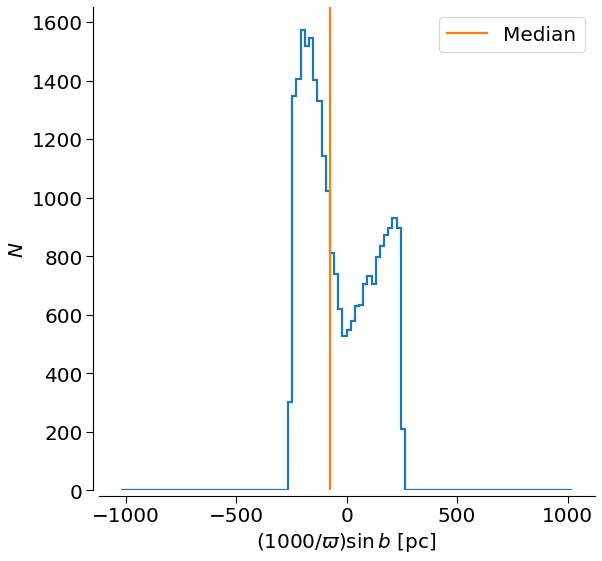

In [6]:
fig, axdsinb = plt.subplots(1, 1, figsize=(8,8))
apply_tufte(axdsinb)

dsinb = (np.sin(np.deg2rad(fgkmtable['b']))*1000.0/fgkmtable['parallax'])[sample_filter]
print(f"Median d*sin(b): {np.median(dsinb):.1f}")
print(f"RSE d*sin(b): {rse(dsinb):.1f}")
print(f"Mean d*sin(b): {dsinb.mean():.1f}")
zsun = 0.0*u.pc #-np.median(dsinb)*u.pc

axdsinb.hist(dsinb, bins='auto', histtype='step', lw=2, range=[-1020,1020])
axdsinb.axvline(x=np.median(dsinb), color='C1', label='Median')
axdsinb.set_xlabel(r'$(1000/\varpi)\sin b$ [pc]')
axdsinb.set_ylabel(r'$N$')
axdsinb.legend()

plt.show()

## Plot the sample proper motions as a function of galactic longitude

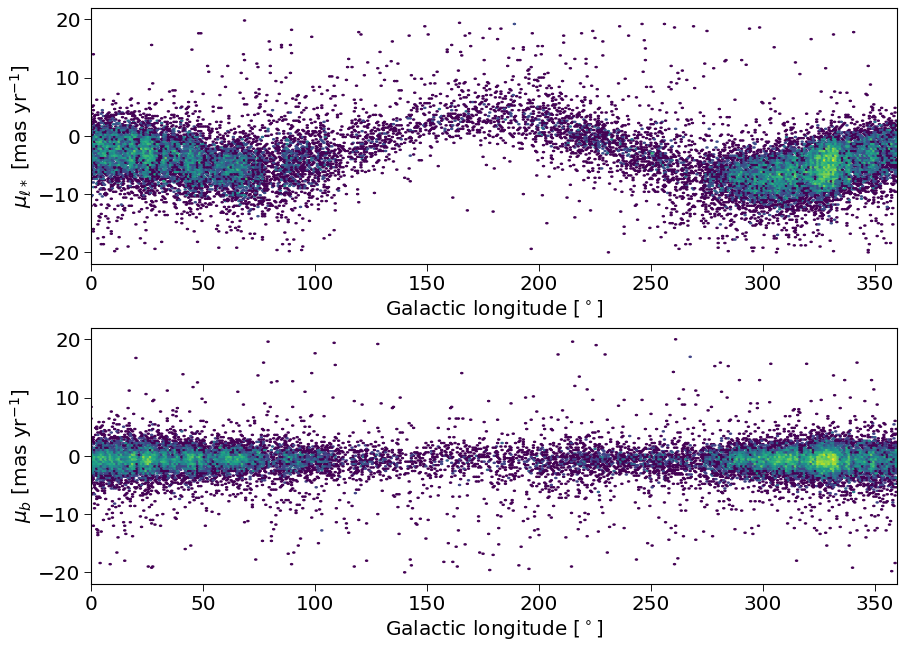

In [7]:
fig=plt.figure(constrained_layout=True, figsize=(0.8*14,0.8*10))

gs = GridSpec(2, 1, figure=fig)

ax_lmul = fig.add_subplot(gs[0,0])
im_lmul = ax_lmul.hexbin(fgkmtable['l'][sample_filter], fgkmtable['pml'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmul.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmul.set_ylabel(r'$\mu_{\ell*}$ [mas yr$^{-1}$]')
ax_lmul.set_xlim(0,360)

ax_lmub = fig.add_subplot(gs[1,0])
im_lmub = ax_lmub.hexbin(fgkmtable['l'][sample_filter], fgkmtable['pmb'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmub.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmub.set_ylabel(r'$\mu_b$ [mas yr$^{-1}$]')
ax_lmub.set_xlim(0,360)

plt.savefig('fgkmstar-pml-pmb-vs-galon.png')

plt.show()

## Set up the Stan model

In [8]:
nsources = fgkm_subsample['ra'].size
print(f"Number of sources in sample: {nsources}")

fgkm_data = {'N': nsources, 
            'galon': np.deg2rad(fgkm_subsample['l']).tolist(), 
            'galat': np.deg2rad(fgkm_subsample['b']).tolist(),
            'pml_obs': fgkm_subsample['pml'].tolist(),
            'pml_obs_unc': fgkm_subsample['pml_error'].tolist(),
            'pmb_obs': fgkm_subsample['pmb'].tolist(),
            'pmb_obs_unc': fgkm_subsample['pmb_error'].tolist(),
            'pml_pmb_corr': fgkm_subsample['pml_pmb_corr'].tolist(),
            'plx_obs': fgkm_subsample['parallax'].tolist(),
            'Rsun': Rsun.value,
            'Zsun':zsun.value
            }
with open('fgkm.data.json', 'w') as fp:
    ujson.dump(fgkm_data, fp)
    fp.close()
    
declining_vcirc_disptens_model = {'stanfile':'mwdisk-declining-vcirc-disptens-model.stan', 
               'npars':7,
               'parnames':['Vcirc_sun', 'dVcirc_dVr', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy', 'vdispz'],
               'labels':[r'$V_{\mathrm{circ},\odot}$', r'$dV_\mathrm{circ}/dV_R$', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'], 
               'inits':{'Vcirc_sun':220.0, 'dVcirc_dVr':0.0, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':10.0, 'vdispz':10.0},
               'best_params':{'Vcirc_sun':np.nan, 'dVcirc_dVr':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'vdispxy':np.nan, 'vdispz':np.nan}
              }

declining_vcirc_disptens_rsunfree_model = {'stanfile':'mwdisk-declining-vcirc-disptens-rsunfree-model.stan', 
               'npars':8,
               'parnames':['Vcirc_sun', 'dVcirc_dVr', 'Rsun', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy', 'vdispz'],
               'labels':[r'$V_{\mathrm{circ},\odot}$', r'$dV_\mathrm{circ}/dV_R$', r'$R_\odot$', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'], 
               'inits':{'Vcirc_sun':220.0, 'dVcirc_dVr':0.0, 'Rsun':8.0, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':10.0, 'vdispz':10.0},
               'best_params':{'Vcirc_sun':np.nan, 'dVcirc_dVr':np.nan, 'Rsun':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan,
                              'vdispxy':np.nan, 'vdispz':np.nan}
              }

stan_model = declining_vcirc_disptens_model

distsunfree = False
if stan_model['stanfile'] == 'mwdisk-declining-vcirc-disptens-rsunfree-model.stan':
    distsunfree = True

Number of sources in sample: 3000


## Sample posterior

Feed the FGKM star proper motion and parallax data to the Stan model and sample the posterior for the Milky Way parameters.

In [9]:
fgkm_stan = os.path.join(os.getcwd(), stan_model['stanfile'])
set_cmdstan_path(os.path.join(os.getenv('HOME'), 'cmdstan'))
fgkm_data_path = os.path.join(os.getcwd(), 'fgkm.data.json')

nwarmup = 500
nsampling = 1000
nchains = 4

fgkm_model = CmdStanModel(stan_file=fgkm_stan)
fgkm_fit = fgkm_model.sample(chains=nchains, iter_warmup=nwarmup, iter_sampling=nsampling, thin=1, data=fgkm_data_path, save_warmup=False, show_progress='notebook')
#fgkm_fit = fgkm_model.sample(chains=4, inits=stan_model['inits'], iter_warmup=500, iter_sampling=1000, thin=1, 
#                           data=fgkm_data_path, save_warmup=False, show_progress='notebook')

21:27:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:29:39 - cmdstanpy - INFO - CmdStan done processing.
21:29:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: mwdisk_declining_vcirc_disptens_model_model_namespace::log_prob: dcov is not symmetric. dcov[1,2] = 0.000304611, but dcov[2,1] = -0.000612084 (in '/home/brown/Gaia/Outreach/C9OUTR-206/milkyway-disk-proper-motions/notebooks/mwdisk-declining-vcirc-disptens-model.stan', line 157, column 2 to column 30)
	Exception: mwdisk_declining_vcirc_disptens_model_model_namespace::log_prob: dcov is not symmetric. dcov[1,2] = 0.000304611, but dcov[2,1] = -0.000153736 (in '/home/brown/Gaia/Outreach/C9OUTR-206/milkyway-disk-proper-motions/notebooks/mwdisk-declining-vcirc-disptens-model.stan', line 157, column 2 to column 30)
	Exception: mwdisk_declining_vcirc_disptens_model_model_namespace::log_prob: dcov is not symmetric. dcov[1,2] = -0.000122535, but dcov[2,1] = -0.000122238 (in '/home/brown/Gaia/Outreach/C9OUTR-206/milkyway-disk-proper-motions/notebooks/mwdisk-declining-v

In [10]:
fgkm_fit.summary()[0:stan_model['npars']+1]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-8094.830000,0.046366,1.905500,-8098.510000,-8094.480000,-8092.39000,1688.93,4.69205,1.000580
Vcirc_sun,225.395000,0.046787,3.238730,219.976000,225.384000,230.77000,4791.74,13.31200,0.999414
dVcirc_dVr,0.463785,0.010569,0.628617,-0.564063,0.457884,1.49150,3537.59,9.82784,0.999486
Vsun_pec_x,12.889000,0.013432,0.974891,11.251500,12.881000,14.46440,5267.82,14.63460,0.999416
Vsun_pec_y,27.844900,0.023661,1.320650,25.639400,27.850700,30.01830,3115.37,8.65487,0.999608
Vsun_pec_z,8.538900,0.004965,0.380757,7.910270,8.545030,9.13929,5881.52,16.33960,0.999324
vdispxy,35.192700,0.006135,0.451560,34.455900,35.188200,35.94240,5417.08,15.04930,0.999980
vdispz,20.515300,0.003903,0.272653,20.072100,20.511000,20.97220,4880.11,13.55750,0.999576


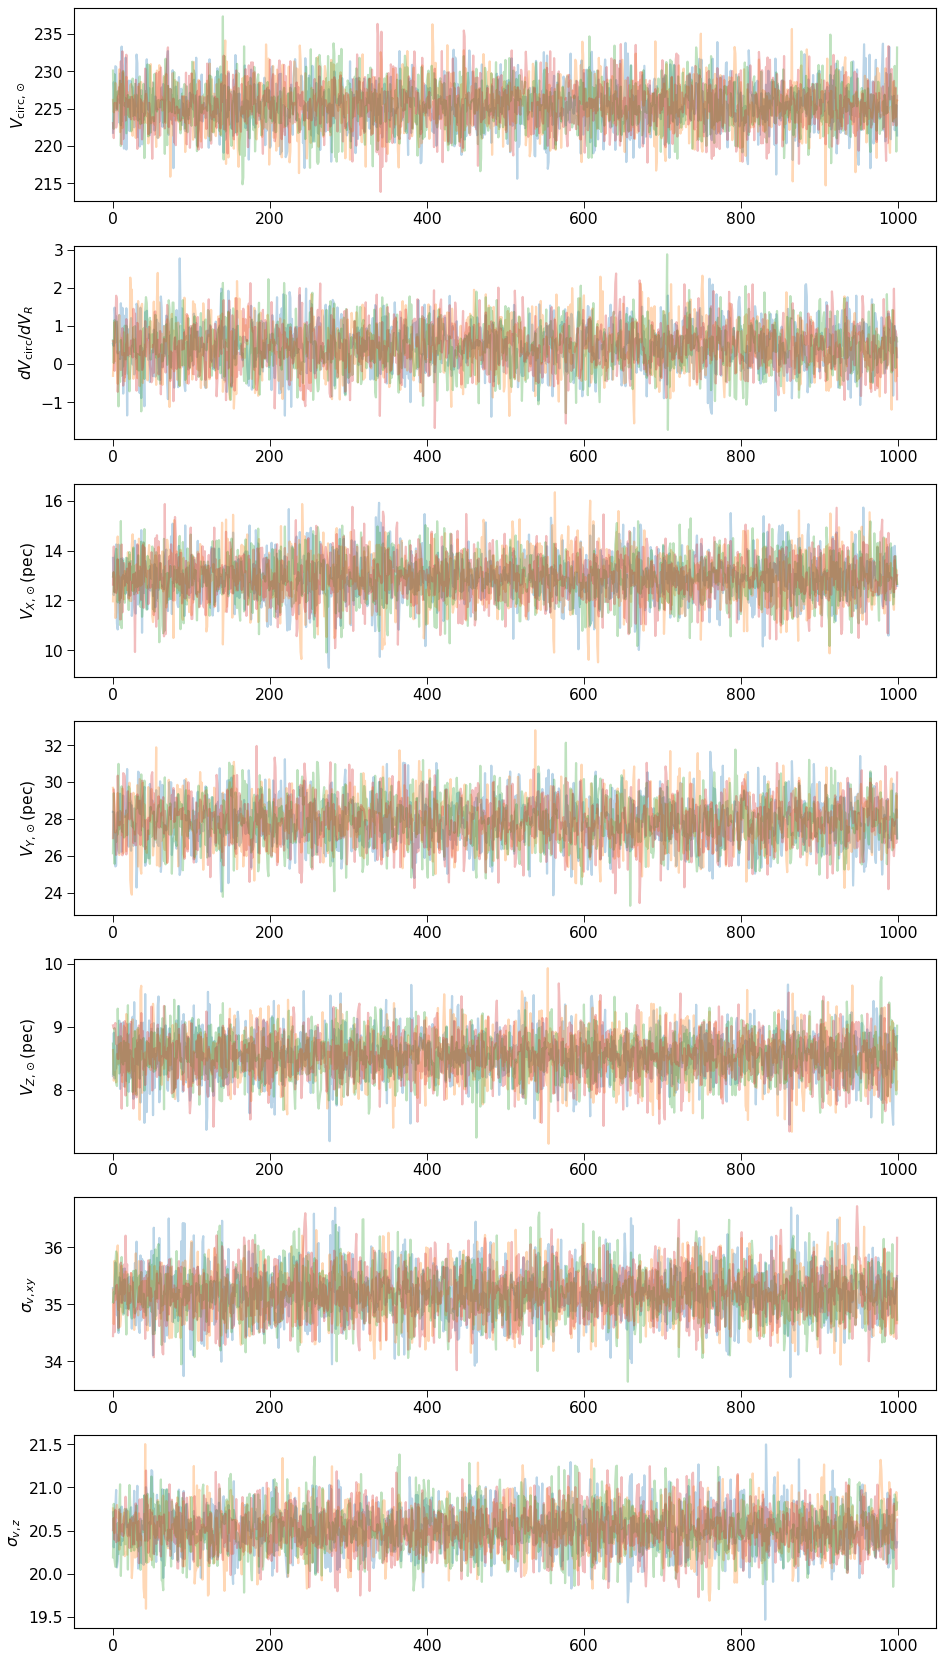

In [11]:
useagab(usetex=False, fontfam='sans-serif', fontsize=14, ncolors=10)

fig, axes = plt.subplots(ncols=1, nrows=stan_model['npars'], tight_layout=True, figsize=(12,3*stan_model['npars']))

for i, lab in zip(range(stan_model['npars']), stan_model['labels']):
    axes[i].plot(fgkm_fit.draws()[:,:,7+i], alpha=0.3)
    axes[i].set_ylabel(lab)

plt.show()

Vcirc_sun = 225.4+3.2-3.2
dVcirc_dVr = 0.5+0.6-0.6
Vsun_pec_x = 12.9+1.0-0.9
Vsun_pec_y = 27.9+1.3-1.4
Vsun_pec_z = 8.5+0.4-0.4
vdispxy = 35.2+0.5-0.4
vdispz = 20.5+0.3-0.3


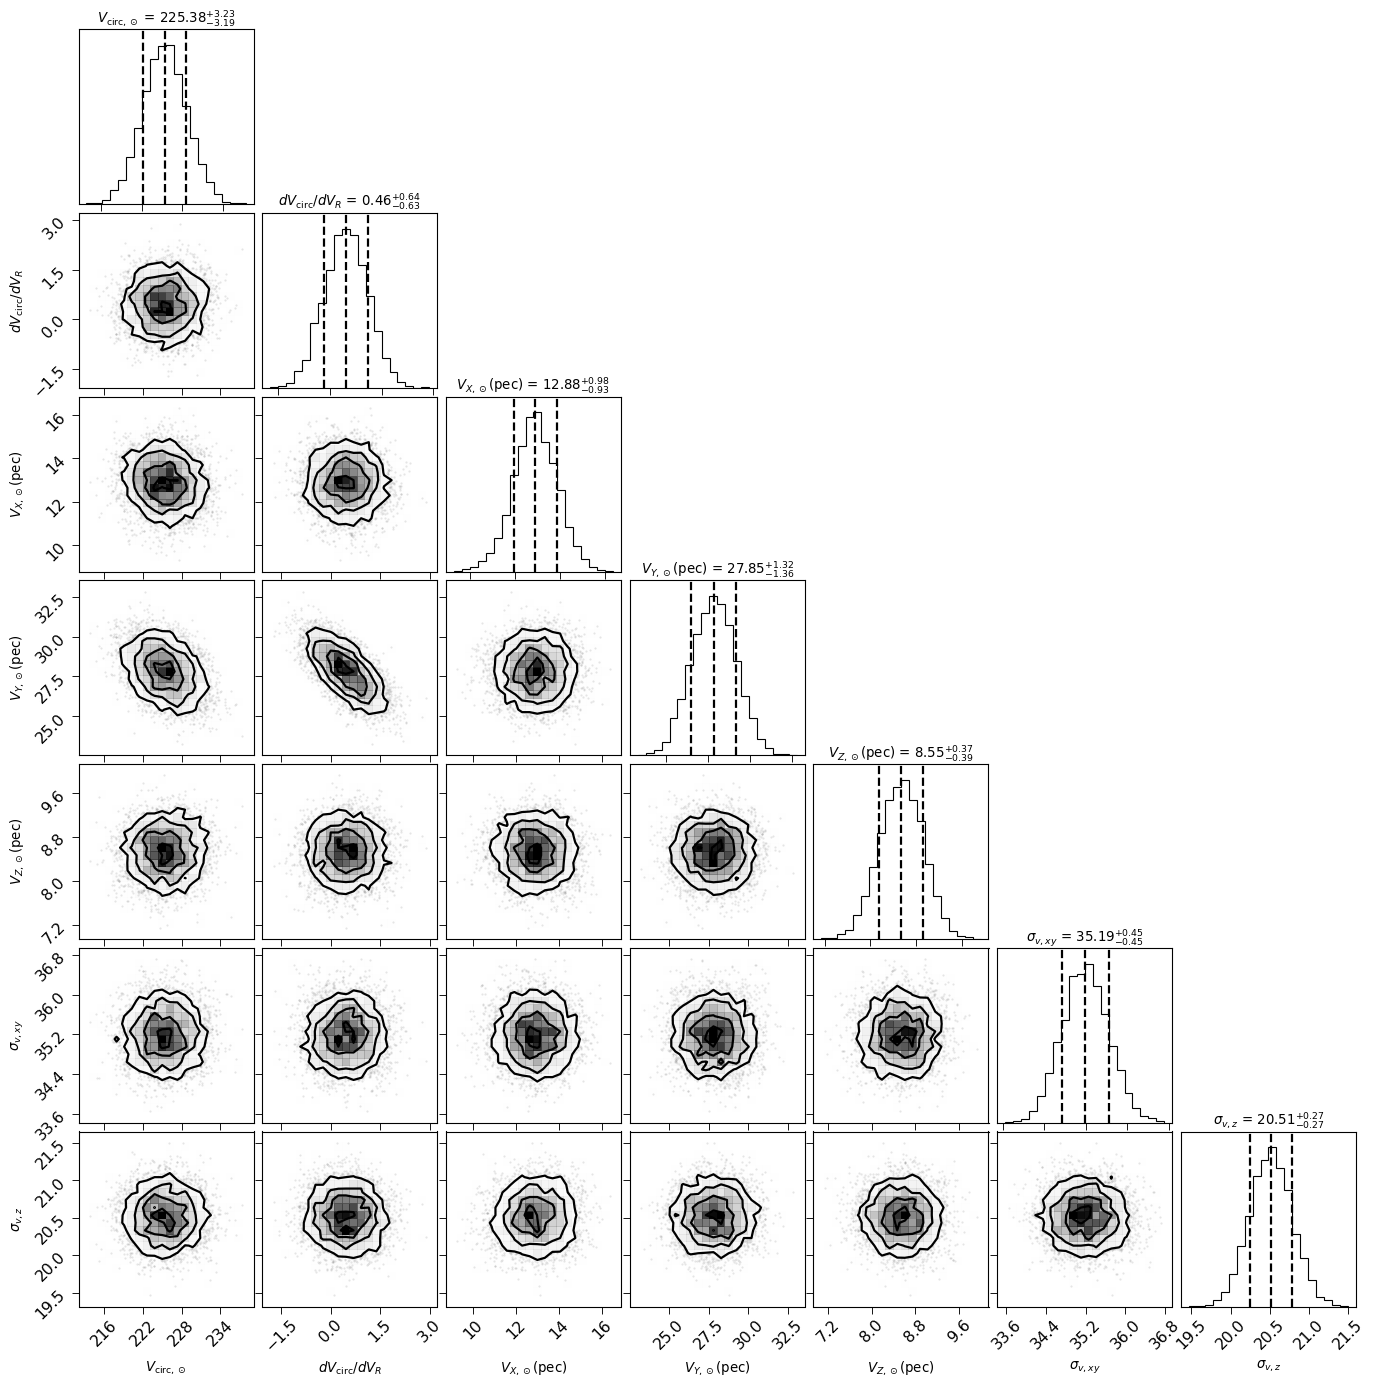

In [12]:
for par in stan_model['parnames']:
    vals = fgkm_fit.stan_variable(par)
    stan_model['best_params'][par] = np.median(vals)
    q1, q2, q3 = scap(vals, [16, 50, 84])
    print(f"{par} = {q2:.1f}+{q3-q2:.1f}-{q2-q1:.1f}")
    
sample_lists = []
for i, par in zip(range(7, 7+stan_model['npars']), stan_model['parnames']):
    sample_lists.append(fgkm_fit.draws()[:,:,i].flatten())
samples = np.vstack(sample_lists).transpose()
                         
useagab(usetex=False, fontfam='sans-serif', fontsize=14, ncolors=10)

figcorner = plt.figure(figsize=(2.5*stan_model['npars'],2.5*stan_model['npars']))
corner.corner(
    samples, labels=stan_model['labels'], 
    label_kwargs={"fontsize":12}, title_kwargs={"fontsize": 12},
    truth_color='r', quantiles=[0.16,0.50,0.84], show_titles=True, fig=figcorner
)
plt.show()

## Sgr A* proper motion (assuming no intrinsic motion for this source) and Oort constants

In [13]:
if distsunfree:
    Rsun = stan_model['best_params']['Rsun']*1000.0*u.pc
    
vsunx_samples = fgkm_fit.draws()[:,:,9].flatten()
vsuny_samples = fgkm_fit.draws()[:,:,10].flatten()+fgkm_fit.draws()[:,:,7].flatten()
vsunz_samples = fgkm_fit.draws()[:,:,11].flatten()
vsunvec_samples = np.vstack([vsunx_samples, vsuny_samples, vsunz_samples])

vsun_circ_samples = fgkm_fit.draws()[:,:,7].flatten()
slope_samples = fgkm_fit.draws()[:,:,8].flatten()

ra_sgr = (17.0+45.0/60.0+40.0409/3600.0)*15
dec_sgr = -29 - 28.118/2300
l_sgr, b_sgr = ct.transform_sky_coordinates(np.deg2rad(ra_sgr), np.deg2rad(dec_sgr))
print(np.rad2deg(l_sgr)-360, np.rad2deg(b_sgr))

p_sgr = np.array([-np.sin(l_sgr), np.cos(l_sgr), 0.0])
q_sgr = np.array([-np.sin(b_sgr)*np.cos(l_sgr), -np.sin(b_sgr)*np.sin(l_sgr), np.cos(b_sgr)])

mu_sgr_xy_samples = -np.dot(p_sgr, vsunvec_samples)/(Rsun*au_km_year_per_sec).value*1000
mu_sgr_z_samples = -np.dot(q_sgr, vsunvec_samples)/(Rsun*au_km_year_per_sec).value*1000
mu_sgr_xy = np.median(mu_sgr_xy_samples)
mu_sgr_xy_rse = rse(mu_sgr_xy_samples)
mu_sgr_z = np.median(mu_sgr_z_samples)
mu_sgr_z_rse = rse(mu_sgr_z_samples)

print(f"mu_sgr_xy = {mu_sgr_xy:.2f}  +/- {mu_sgr_xy_rse:.3f}")
print(f"mu_sgr_z = {mu_sgr_z:.2f}  +/- {mu_sgr_z_rse:.3f}")

oortA_samples = (vsun_circ_samples/Rsun.value*1000 - slope_samples)/2
oortB_samples = (-vsun_circ_samples/Rsun.value*1000 - slope_samples)/2
oortAminB_samples = oortA_samples - oortB_samples
oortA = np.median(oortA_samples)
oortA_rse = rse(oortA_samples)
oortB = np.median(oortB_samples)
oortB_rse = rse(oortB_samples)
oortAminB = np.median(oortAminB_samples)
oortAminB_rse = rse(oortAminB_samples)

print(f"Oort A = {oortA:.2f}  +/- {oortA_rse:.3f}")
print(f"Oort B = {oortB:.2f}  +/- {oortB_rse:.3f}")
print(f"Oort A-B = {oortAminB:.2f}  +/- {oortAminB_rse:.3f}")

-0.05951722261414716 -0.04846468783279137
mu_sgr_xy = -6.46  +/- 0.078
mu_sgr_z = -0.22  +/- 0.010
Oort A = 13.39  +/- 0.364
Oort B = -13.84  +/- 0.378
Oort A-B = 27.23  +/- 0.395


## Model check through predictive posterior

In [14]:
idata = az.from_cmdstanpy(
    posterior=fgkm_fit,
    posterior_predictive=['pred_pml', 'pred_pmb'],
    observed_data={'pml_obs': fgkm_data['pml_obs'],
                   'pmb_obs': fgkm_data['pmb_obs']},
    coords={'nsources': np.arange(fgkm_data['N'])},
    dims={
        'pml_obs': ['nsources'],
        'pmb_obs': ['nsources'],
        'pred_pml': ['nsources'],
        'pred_pmb': ['nsources'],
    },
)

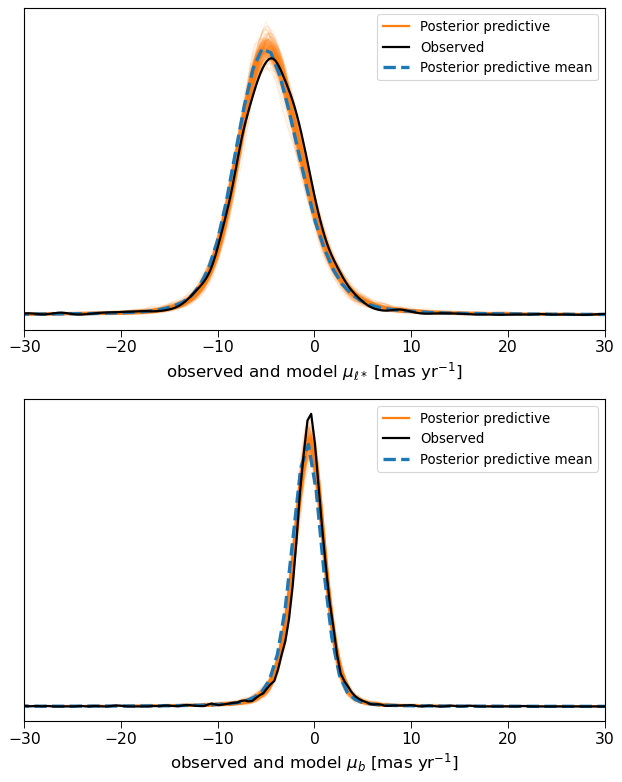

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(8, 2*5), tight_layout=True)
az.plot_ppc(idata, ax=axes, data_pairs={'pml_obs':'pred_pml', 'pmb_obs':'pred_pmb'}, 
            num_pp_samples=200, alpha=0.1, colors=['C1', 'k', 'C0'])
for ax in axes:
    ax.legend(fontsize=12)
    #apply_tufte(ax)
axes[0].set_xlim(-30,30)
axes[1].set_xlim(-30,30)
axes[0].set_xlabel(r'observed and model $\mu_{\ell*}$ [mas yr$^{-1}$]')
axes[1].set_xlabel(r'observed and model $\mu_b$ [mas yr$^{-1}$]')

plt.savefig('fgkmstars_pms_posterior_predictive.png')

plt.show()

## Compare model predictions and observations in the proper motion vs longitude plots

In [16]:
sunpos = np.array([-Rsun.value, 0, zsun.value])*u.pc
vsunpeculiar = np.array([stan_model['best_params']['Vsun_pec_x'], stan_model['best_params']['Vsun_pec_y'], stan_model['best_params']['Vsun_pec_z']])*u.km/u.s
vcircsun = stan_model['best_params']['Vcirc_sun']
slope = stan_model['best_params']['dVcirc_dVr']

diskmodel_flat = DiskKinematicModel(SlopedRotationCurve(vcircsun, Rsun.value, slope), sunpos, vsunpeculiar)

2751.524850019789


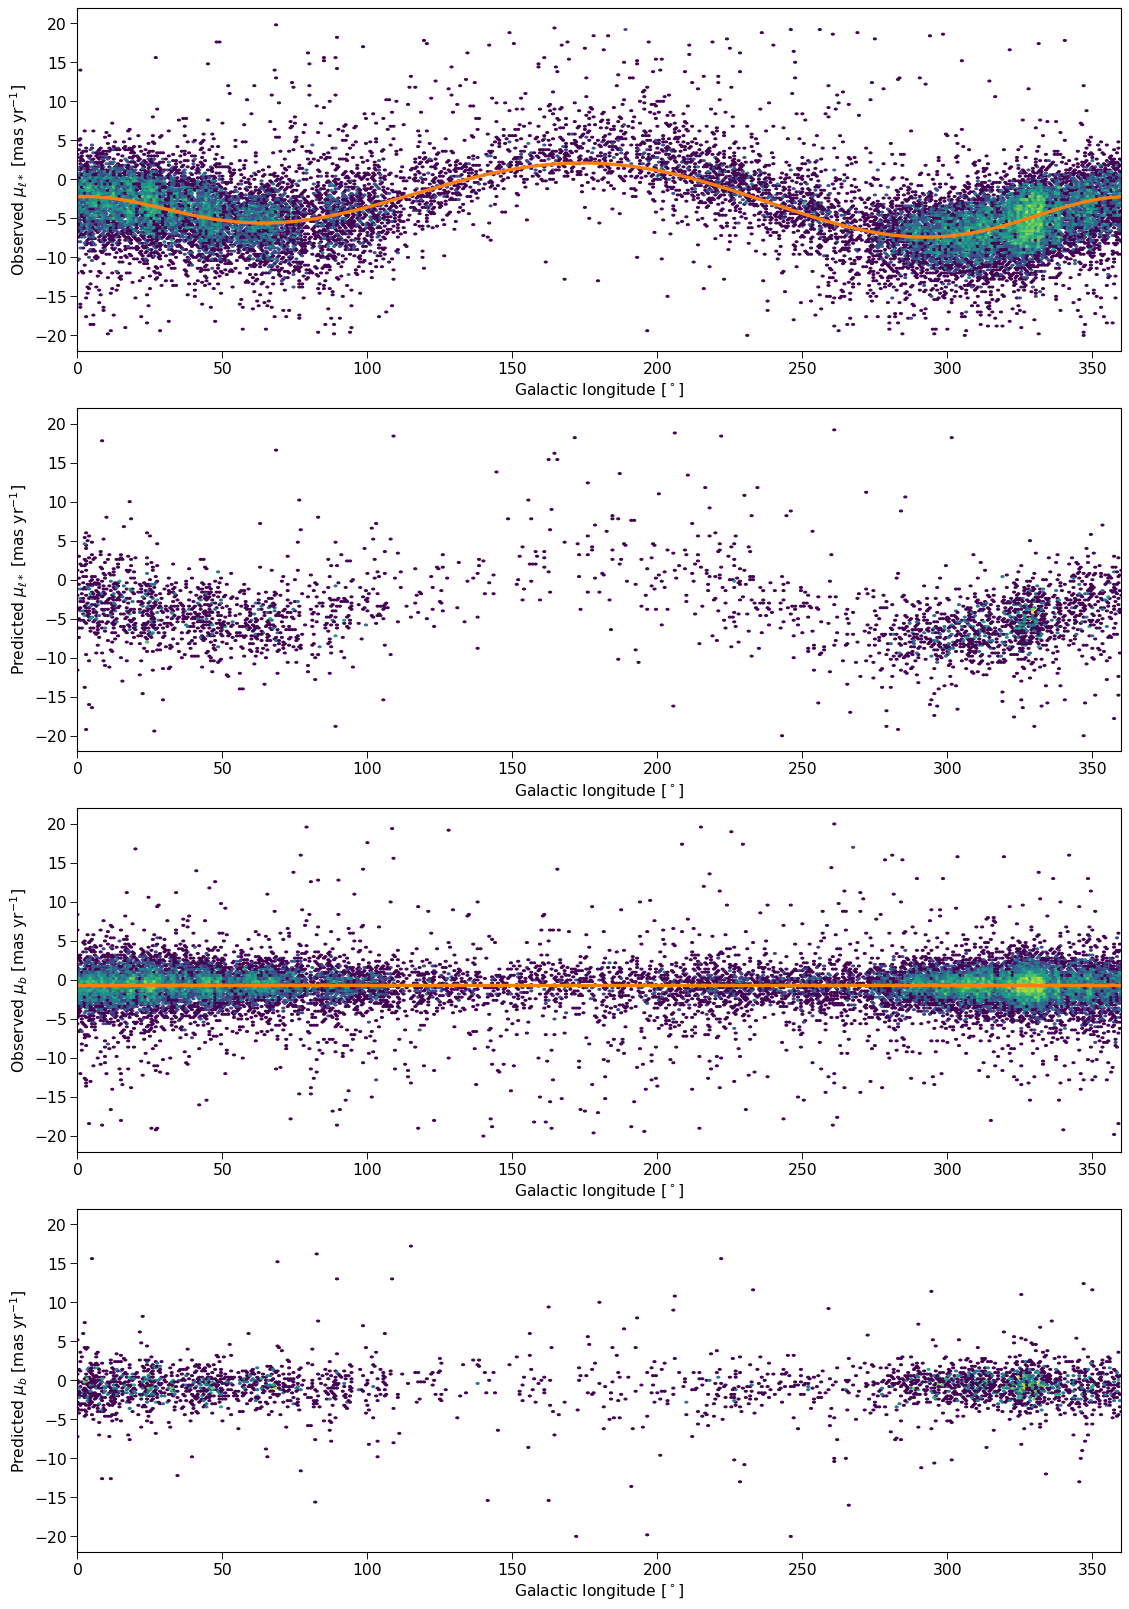

In [17]:
galon = np.linspace(0,360,361)*u.deg

median_dist = 1000/np.median(fgkmtable['parallax'][sample_filter])
print(median_dist)

#pml_model, pmb_model, vrad_model = diskmodel_flat.observables(1000.0/fgkmtable['parallax'][sample_filter].value*u.pc, 
#                                                              fgkmtable['l'][sample_filter]*u.deg, fgkmtable['b'][sample_filter]*u.deg)

chain = np.random.choice(nchains)
mcsample = np.random.choice(nsampling)

fig=plt.figure(constrained_layout=True, figsize=(14,4*5))

gs = GridSpec(4, 1, figure=fig)

ax_lmul = fig.add_subplot(gs[0,0])
im_lmul = ax_lmul.hexbin(fgkmtable['l'][sample_filter], fgkmtable['pml'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmul.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmul.set_ylabel(r'Observed $\mu_{\ell*}$ [mas yr$^{-1}$]')
ax_lmul.set_xlim(0,360)

ax_lmul_model = fig.add_subplot(gs[1,0])
#im_lmul_model = ax_lmul_model.hexbin(fgkmtable['l'][sample_filter], pml_model, 
#                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
im_lmul_model = ax_lmul_model.hexbin(fgkm_subsample['l'], idata.posterior_predictive['pred_pml'][chain, mcsample, :], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmul_model.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmul_model.set_ylabel(r'Predicted $\mu_{\ell*}$ [mas yr$^{-1}$]')
ax_lmul_model.set_xlim(0,360)

ax_lmub = fig.add_subplot(gs[2,0])
im_lmub = ax_lmub.hexbin(fgkmtable['l'][sample_filter], fgkmtable['pmb'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmub.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmub.set_ylabel(r'Observed $\mu_b$ [mas yr$^{-1}$]')
ax_lmub.set_xlim(0,360)

ax_lmub_model = fig.add_subplot(gs[3,0])
#im_lmub_model = ax_lmub_model.hexbin(fgkmtable['l'][sample_filter], pmb_model, 
#                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
im_lmub_model = ax_lmub_model.hexbin(fgkm_subsample['l'], idata.posterior_predictive['pred_pmb'][chain, mcsample, :], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmub_model.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmub_model.set_ylabel(r'Predicted $\mu_b$ [mas yr$^{-1}$]')
ax_lmub_model.set_xlim(0,360)

for dist in [median_dist]:
    distance = np.zeros_like(galon.value) + dist*u.pc
    galat = np.zeros_like(galon.value) - np.rad2deg(np.arcsin(zsun.value/dist))*u.deg
    pml_model, pmb_model, vrad_model = diskmodel_flat.observables(distance, galon, galat)
    ax_lmul.plot(galon, pml_model, c='C1', lw=3, label=rf'$d={dist:.0f}$ pc')
    ax_lmub.plot(galon, pmb_model, c='C1', lw=3)

plt.show()

## Overplot model predictions for specific distances on observed proper motions

2751.524850019789


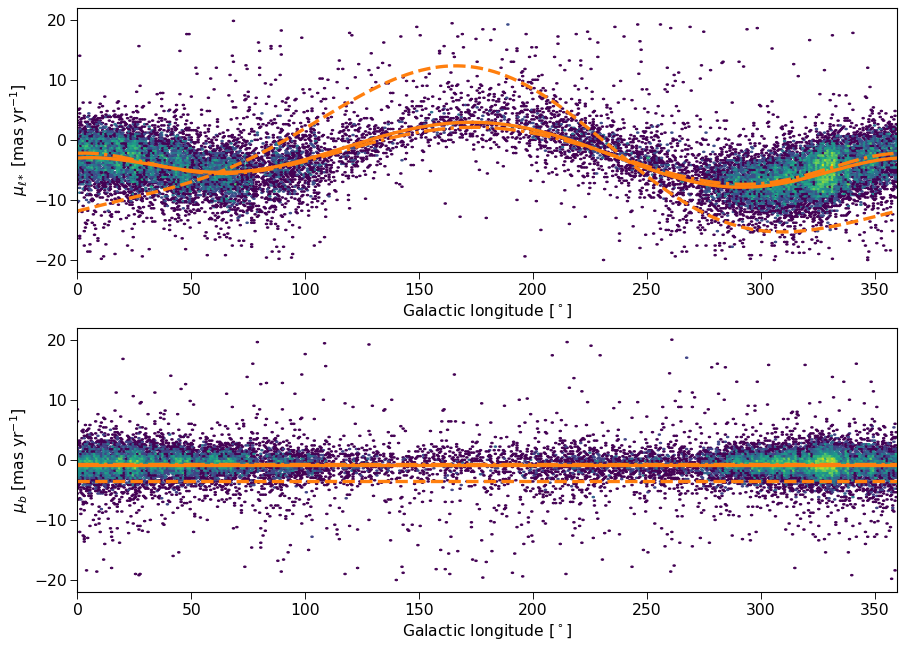

In [18]:
fig=plt.figure(constrained_layout=True, figsize=(0.8*14,0.8*10))

gs = GridSpec(2, 1, figure=fig)

ax_lmul = fig.add_subplot(gs[0,0])
im_lmul = ax_lmul.hexbin(fgkmtable['l'][sample_filter], fgkmtable['pml'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmul.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmul.set_ylabel(r'$\mu_{\ell*}$ [mas yr$^{-1}$]')
ax_lmul.set_xlim(0,360)

ax_lmub = fig.add_subplot(gs[1,0])
im_lmub = ax_lmub.hexbin(fgkmtable['l'][sample_filter], fgkmtable['pmb'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmub.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmub.set_ylabel(r'$\mu_b$ [mas yr$^{-1}$]')
ax_lmub.set_xlim(0,360)

print(median_dist)
for dist, lstyle in zip([500, median_dist, 2000], ['--C1', '-.C1', '-C1']):
    distance = np.zeros_like(galon.value) + dist*u.pc
    galat = np.zeros_like(galon.value) - np.rad2deg(np.arcsin(zsun.value/dist))*u.deg
    pml_model, pmb_model, vrad_model = diskmodel_flat.observables(distance, galon, galat)
    ax_lmul.plot(galon, pml_model, lstyle, lw=3, label=rf'$d={dist:.0f}$ pc')
    ax_lmub.plot(galon, pmb_model, lstyle, lw=3)

plt.savefig('fgkmstar-pml-pmb-vs-galon-plusmodel.png')

plt.show()